# CMS Covid-19 Nursing Home Data Analysis
Analysis of data submitted by several nursing homes to the CDC's National Healthcare Safety Network (NHSN) COVID-19 Long Term Care Facility Module from 2020 to 2022. \

The data is openly available at [CMS](https://data.cms.gov/covid-19/covid-19-nursing-home-data) \

The data dictionary is available [Here](https://data.cms.gov/sites/default/files/2022-09/COVID-19%20Nursing%20Home%20Data%20Dictionary%209.1.22.pdf)


- Author: Debanjan Saha
- PI: Prof. S. Radhakrishnan
- Affiliation: College of Engineering, Northeastern University, Boston, MA


Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [2]:
from io import IncrementalNewlineDecoder
import numbers
from typing import Optional
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px

### Read Data

In [3]:
raw_data = pd.read_csv('/content/drive/MyDrive/Northeastern/Labs/IE5374/NursingHome/COVID-19 Nursing Home Data 08.28.2022.csv')
raw_data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,41,42,43,44,45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Week Ending,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,County,Submitted Data,...,Percentage of Current Residents Up to Date with COVID-19 Vaccines with No Medical Contraindications,Percentage of Current Residents with a Completed Vaccination Up to Date with COVID-19 Vaccines,Number of Healthcare Personnel with a Completed Vaccination Staying in this Facility for At Least 1 Day This Week who Received a COVID-19 Vaccine Booster at Any Time,Recent Percentage of Current Healthcare Personnel with a Completed Vaccination who Received a COVID-19 Vaccine Booster at Any Time,Percentage of Current Healthcare Personnel with a Completed Vaccination who Received a COVID-19 Vaccine Booster at Any Time,Number of Healthcare Personnel Eligible to Work in this Facility for At Least 1 Day This Week Up to Date with COVID-19 Vaccines,Recent Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines,Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines,Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines with No Medical Contraindications,Percentage of Current Healthcare Personnel with a Completed Vaccination Up to Date with COVID-19 Vaccines
0,05/24/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,Franklin,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,05/31/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,Franklin,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/07/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,Franklin,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/14/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,Franklin,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/21/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,Franklin,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
raw_data.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816451 entries, 0 to 1816450
Columns: 120 entries, Week Ending to Percentage of Current Healthcare Personnel with a Completed Vaccination Up to Date with COVID-19 Vaccines
dtypes: float64(96), int64(2), object(22)
memory usage: 3.3 GB


In [5]:
# Display the number of rows and columns
print("Number of rows: {}".format(raw_data.shape[0]))
print("Number of cols: {}".format(raw_data.shape[1]))

Number of rows: 1816451
Number of cols: 120


## Data Investigation

In [6]:
raw_data.dtypes

Week Ending                                                                                                                         object
Federal Provider Number                                                                                                             object
Provider Name                                                                                                                       object
Provider Address                                                                                                                    object
Provider City                                                                                                                       object
                                                                                                                                    ...   
Number of Healthcare Personnel Eligible to Work in this Facility for At Least 1 Day This Week Up to Date with COVID-19 Vaccines    float64
Recent Percentage of Curren

### Memory Optimization

#### Downcast Int & Float Datatype

In [7]:
np_types = [np.int8 ,np.int16 ,np.int32, np.int64,
           np.uint8 ,np.uint16, np.uint32, np.uint64]
np_types = [np_type.__name__ for np_type in np_types]
type_df = pd.DataFrame(data=np_types, columns=['class_type'])
type_df['min_value'] = type_df['class_type'].apply(lambda row: np.iinfo(row).min)
type_df['max_value'] = type_df['class_type'].apply(lambda row: np.iinfo(row).max)
type_df['range'] = type_df['max_value'] - type_df['min_value']
type_df.sort_values(by='range', inplace=True)
type_df

,class_type,min_value,max_value,range
0,int8,-128,127,2.550000e+02
4,uint8,0,255,2.550000e+02
1,int16,-32768,32767,6.553500e+04
5,uint16,0,65535,6.553500e+04
2,int32,-2147483648,2147483647,4.294967e+09
6,uint32,0,4294967295,4.294967e+09
3,int64,-9223372036854775808,9223372036854775807,1.844674e+19
7,uint64,0,18446744073709551615,1.844674e+19


In [8]:
def auto_opt_pd_dtypes(df_: pd.DataFrame, inplace=False) -> Optional[pd.DataFrame]:
    """ Automatically downcast Number dtypes for minimal possible,
        will not touch other (datetime, str, object, etc)
        Original Implementation by banderlog013
        https://stackoverflow.com/a/67403354
        Improvement in data size by Debanjan Saha
        
        :param df_: dataframe
        :param inplace: if False, will return a copy of input dataset
        
        :return: `None` if `inplace=True` or dataframe if `inplace=False`
    """
    df = df_ if inplace else df_.copy()
        
    for col in df.columns:
        # integers
        if issubclass(df[col].dtypes.type, numbers.Integral):
            col_min = df[col].min()
            col_max = df[col].max()
            temp = type_df[(type_df['min_value'] <= col_min) & (type_df['max_value'] >= col_max)]
            optimized_class = temp.loc[temp['range'].idxmin(), 'class_type']
            # print("Col name : {} Col min_value : {} Col max_value : {} Optimized Class : {}".format(col, col_min, col_max, optimized_class))
            df[col] = df[col].astype(optimized_class)
        # other real numbers
        elif issubclass(df[col].dtypes.type, numbers.Real):
            df[col] = pd.to_numeric(df[col], downcast='float')
    
    if not inplace:
        return df

In [9]:
raw_data.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816451 entries, 0 to 1816450
Columns: 120 entries, Week Ending to Percentage of Current Healthcare Personnel with a Completed Vaccination Up to Date with COVID-19 Vaccines
dtypes: float64(96), int64(2), object(22)
memory usage: 3.3 GB


In [10]:
auto_opt_pd_dtypes(raw_data, inplace=True)
raw_data.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816451 entries, 0 to 1816450
Columns: 120 entries, Week Ending to Percentage of Current Healthcare Personnel with a Completed Vaccination Up to Date with COVID-19 Vaccines
dtypes: float32(96), int32(1), int64(1), object(22)
memory usage: 2.6 GB


### Dimension Data Type Modification

In [11]:
def set_col_last_first(df):
    """Function to set the last column as the first column"""
    original_cols = df.columns.tolist()
    reorder_cols = original_cols[-1:] + original_cols[:-1]
    df = df[reorder_cols]
    return df

In [12]:
raw_data['facility_id'] = raw_data['Federal Provider Number'].astype('str')
raw_data = set_col_last_first(raw_data)
raw_data.head()

,facility_id,Week Ending,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,County,...,Percentage of Current Residents Up to Date with COVID-19 Vaccines with No Medical Contraindications,Percentage of Current Residents with a Completed Vaccination Up to Date with COVID-19 Vaccines,Number of Healthcare Personnel with a Completed Vaccination Staying in this Facility for At Least 1 Day This Week who Received a COVID-19 Vaccine Booster at Any Time,Recent Percentage of Current Healthcare Personnel with a Completed Vaccination who Received a COVID-19 Vaccine Booster at Any Time,Percentage of Current Healthcare Personnel with a Completed Vaccination who Received a COVID-19 Vaccine Booster at Any Time,Number of Healthcare Personnel Eligible to Work in this Facility for At Least 1 Day This Week Up to Date with COVID-19 Vaccines,Recent Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines,Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines,Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines with No Medical Contraindications,Percentage of Current Healthcare Personnel with a Completed Vaccination Up to Date with COVID-19 Vaccines
0,15009,05/24/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,Franklin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15009,05/31/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,Franklin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15009,06/07/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,Franklin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15009,06/14/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,Franklin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15009,06/21/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,Franklin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
raw_data['week_ending_ts'] = pd.to_datetime(raw_data['Week Ending'])
raw_data = set_col_last_first(raw_data)
raw_data.head()

,week_ending_ts,facility_id,Week Ending,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,...,Percentage of Current Residents Up to Date with COVID-19 Vaccines with No Medical Contraindications,Percentage of Current Residents with a Completed Vaccination Up to Date with COVID-19 Vaccines,Number of Healthcare Personnel with a Completed Vaccination Staying in this Facility for At Least 1 Day This Week who Received a COVID-19 Vaccine Booster at Any Time,Recent Percentage of Current Healthcare Personnel with a Completed Vaccination who Received a COVID-19 Vaccine Booster at Any Time,Percentage of Current Healthcare Personnel with a Completed Vaccination who Received a COVID-19 Vaccine Booster at Any Time,Number of Healthcare Personnel Eligible to Work in this Facility for At Least 1 Day This Week Up to Date with COVID-19 Vaccines,Recent Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines,Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines,Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines with No Medical Contraindications,Percentage of Current Healthcare Personnel with a Completed Vaccination Up to Date with COVID-19 Vaccines
0,2020-05-24,15009,05/24/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-31,15009,05/31/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-06-07,15009,06/07/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-06-14,15009,06/14/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-06-21,15009,06/21/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
raw_data['reporting_year'] = raw_data['week_ending_ts'].dt.year.astype(str)
raw_data = set_col_last_first(raw_data)
raw_data.head()

,reporting_year,week_ending_ts,facility_id,Week Ending,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,...,Percentage of Current Residents Up to Date with COVID-19 Vaccines with No Medical Contraindications,Percentage of Current Residents with a Completed Vaccination Up to Date with COVID-19 Vaccines,Number of Healthcare Personnel with a Completed Vaccination Staying in this Facility for At Least 1 Day This Week who Received a COVID-19 Vaccine Booster at Any Time,Recent Percentage of Current Healthcare Personnel with a Completed Vaccination who Received a COVID-19 Vaccine Booster at Any Time,Percentage of Current Healthcare Personnel with a Completed Vaccination who Received a COVID-19 Vaccine Booster at Any Time,Number of Healthcare Personnel Eligible to Work in this Facility for At Least 1 Day This Week Up to Date with COVID-19 Vaccines,Recent Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines,Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines,Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines with No Medical Contraindications,Percentage of Current Healthcare Personnel with a Completed Vaccination Up to Date with COVID-19 Vaccines
0,2020,2020-05-24,15009,05/24/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,2020-05-31,15009,05/31/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,2020-06-07,15009,06/07/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,2020-06-14,15009,06/14/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,2020-06-21,15009,06/21/20,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# display data types
raw_data.drop(columns=['Week Ending', 'Federal Provider Number'],
              axis=1, inplace=True)
raw_data.dtypes

reporting_year                                                                                                                             object
week_ending_ts                                                                                                                     datetime64[ns]
facility_id                                                                                                                                object
Provider Name                                                                                                                              object
Provider Address                                                                                                                           object
                                                                                                                                        ...      
Number of Healthcare Personnel Eligible to Work in this Facility for At Least 1 Day This Week Up to Date with COVID-19 Vacci

In [16]:
# display the columns with maximum missing values
raw_data.isna().sum().sort_values(ascending=False)

Gloves No Longer Available in 7 Days            1814582
Gowns No Longer Available in 7 Days             1814582
N95 Respirator No Longer Available in 7 Days    1814580
Eye Protection No Longer Available in 7 Days    1814580
Face Masks No Longer Available in 7 Days        1814579
                                                 ...   
Provider Zip Code                                     0
Provider Phone Number                                 0
County                                                0
Submitted Data                                        0
reporting_year                                        0
Length: 121, dtype: int64

In [17]:
raw_data.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816451 entries, 0 to 1816450
Columns: 121 entries, reporting_year to Percentage of Current Healthcare Personnel with a Completed Vaccination Up to Date with COVID-19 Vaccines
dtypes: datetime64[ns](1), float32(96), int32(1), int64(1), object(22)
memory usage: 2.6 GB


### Dimension Dictionary

In [18]:
# dim_dict = {}
# for i in range(raw_data.shape[1]):
#     # dim_dict["col" + str(i+1)] = raw_data.columns[i]
#     dim_dict[raw_data.columns[i]] = "Col" + str(i)

# # # create list of original column names and transformed column names
# # og_list = list(dim_dict.values())
# # tf_list = list(dim_dict.keys())


In [19]:
# # function to return key for any value
# # https://www.geeksforgeeks.org/python-get-key-from-value-in-dictionary/
# def get_key(ddict, val):
#     for key, value in ddict.items():
#         if val == value:
#             return key

### Transform Column Names

In [20]:
# tf_data = raw_data.copy(deep=True)
# tf_data.rename(columns=dim_dict, inplace=True)
# tf_data.head()

In [21]:
# tf_data = raw_data.copy(deep=True)
# for i in range(tf_data.shape[1]):
#     tf_data.columns.values[i] = tf_list[i]
# tf_data.head()

In [22]:
# # original data
# raw_data.head()

In [23]:
raw_data.describe(include="all")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,reporting_year,week_ending_ts,facility_id,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,County,...,Percentage of Current Residents Up to Date with COVID-19 Vaccines with No Medical Contraindications,Percentage of Current Residents with a Completed Vaccination Up to Date with COVID-19 Vaccines,Number of Healthcare Personnel with a Completed Vaccination Staying in this Facility for At Least 1 Day This Week who Received a COVID-19 Vaccine Booster at Any Time,Recent Percentage of Current Healthcare Personnel with a Completed Vaccination who Received a COVID-19 Vaccine Booster at Any Time,Percentage of Current Healthcare Personnel with a Completed Vaccination who Received a COVID-19 Vaccine Booster at Any Time,Number of Healthcare Personnel Eligible to Work in this Facility for At Least 1 Day This Week Up to Date with COVID-19 Vaccines,Recent Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines,Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines,Percentage of Current Healthcare Personnel Up to Date with COVID-19 Vaccines with No Medical Contraindications,Percentage of Current Healthcare Personnel with a Completed Vaccination Up to Date with COVID-19 Vaccines
count,1816451,1816451,1816451,1816451,1816451,1816451,1816451,1.816451e+06,1.816451e+06,1816451,...,968017.000000,968017.000000,785499.000000,14761.000000,967779.000000,188491.000000,14761.000000,967779.000000,967779.000000,967779.000000
unique,3,119,15514,15230,15439,5266,53,NaN,NaN,1705,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2021,2020-06-14 00:00:00,15009,MILLER'S MERRY MANOR,N2665 CTY RD QQ,CHICAGO,TX,NaN,NaN,Los Angeles,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,793987,15370,119,3570,357,9453,144050,NaN,NaN,45231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2020-05-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-08-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.031145e+04,5.876505e+09,NaN,...,11.334819,12.674280,41.463619,55.661697,28.071257,61.565666,42.913616,8.682266,8.767078,9.734539
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.683933e+04,2.331702e+09,NaN,...,26.839731,29.644533,56.332306,26.410770,29.809027,63.514259,27.670879,21.655041,21.857298,23.696917
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.600000e+02,1.112223e+09,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.982400e+04,3.867585e+09,NaN,...,0.000000,0.000000,4.000000,35.971001,0.000000,21.000000,21.488001,0.000000,0.000000,0.000000


### Numeric and Categorical Features

In [24]:
num_dims = raw_data.columns[raw_data.dtypes != object]
cat_dims = raw_data.columns[raw_data.dtypes == object]

print("Number of numerical dimensions = {}".format(len(num_dims)))
print("Number of categorical dimensions = {}".format(len(cat_dims)))

Number of numerical dimensions = 99
Number of categorical dimensions = 22


### Null Value Counts

In [25]:
print("Column Name -> Number of Null Values ")
print("=======================================================================")
nulls = raw_data.isnull().sum().to_frame()
for index, row in nulls.iterrows(): 
    print(index, " -> ", row[0])

Column Name -> Number of Null Values 
reporting_year  ->  0
week_ending_ts  ->  0
facility_id  ->  0
Provider Name  ->  0
Provider Address  ->  0
Provider City  ->  0
Provider State  ->  0
Provider Zip Code  ->  0
Provider Phone Number  ->  0
County  ->  0
Submitted Data  ->  0
Passed Quality Assurance Check  ->  13292
Residents Weekly Admissions COVID-19  ->  19904
Residents Total Admissions COVID-19  ->  19904
Residents Weekly Confirmed COVID-19  ->  19904
Residents Total Confirmed COVID-19  ->  19904
Residents Weekly All Deaths  ->  19904
Residents Total All Deaths  ->  19904
Residents Weekly COVID-19 Deaths  ->  19904
Residents Total COVID-19 Deaths  ->  19904
Number of All Beds  ->  30115
Total Number of Occupied Beds  ->  26775
Staff Weekly Confirmed COVID-19  ->  19904
Staff Total Confirmed COVID-19  ->  19904
Staff Weekly COVID-19 Deaths  ->  19904
Staff Total COVID-19 Deaths  ->  19904
Shortage of Nursing Staff  ->  180413
Shortage of Clinical Staff  ->  180452
Shortage of Aid

In [26]:
# function to get unique count per column in a data frame
def uniq_cnt_col(df):
    tot_cnt = df.count()
    # Count total number of non-null values
    tmp_df = pd.DataFrame(data=tot_cnt)
    tmp_df.columns = ['Total_NotNull'] 
    distincts = []
    for col in df.columns:
        # Get number of distinct values for each column
        distinct = df[col].nunique() 
        distincts.append(distinct)
    tmp_df['Distincts'] = distincts
    return tmp_df
    # return(np.transpose(tmp_df))

## Data Analytics

### States with the highest number of facilities

In [27]:
fac_df = raw_data.groupby(by='Provider State', as_index=False)['facility_id'].nunique()
sorted_fac_state = fac_df.sort_values(by='facility_id', ascending=False)

In [28]:
px.bar(sorted_fac_state, x='Provider State', y='facility_id', color='Provider State',
       labels={'facility_id':'Count of Facilities'}, height=400)

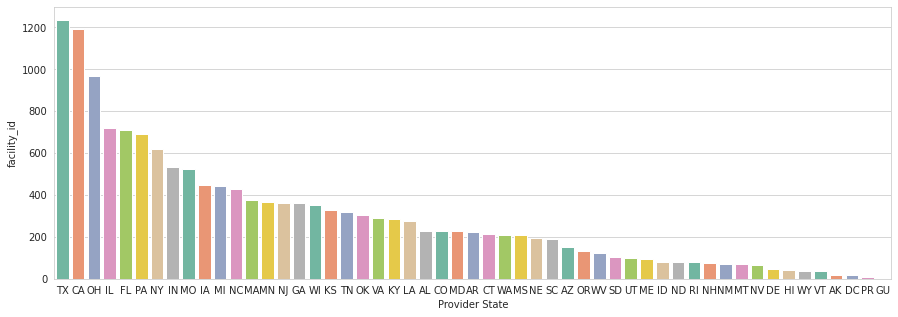

In [29]:
plt.figure(figsize=(15,5))
sns.barplot(x='Provider State', y='facility_id', data=sorted_fac_state,
            palette="Set2")

### Top 10 Cities (along with their states) which has the highest number of facilities

In [30]:
fac_city_df = raw_data.groupby(by=['Provider State', 'Provider City'], as_index=False)['facility_id'].nunique()
sorted_fac_city_state = fac_city_df.sort_values(by='facility_id', ascending=False, ignore_index=True)
sorted_fac_city_state.head(10)

,Provider State,Provider City,facility_id
0,IL,CHICAGO,81
1,CA,LOS ANGELES,79
2,OH,CINCINNATI,73
3,TX,HOUSTON,67
4,TX,SAN ANTONIO,64
5,IN,INDIANAPOLIS,50
6,PA,PHILADELPHIA,48
7,KY,LOUISVILLE,42
8,NY,BRONX,42
9,MD,BALTIMORE,41


### Count of unique facilities reported per year

In [31]:
raw_data.groupby('reporting_year')['facility_id'].nunique()

reporting_year
2020    15416
2021    15408
2022    15226
Name: facility_id, dtype: int64

### Top 10 situations where facilities were not able to handle the covid spread

In [34]:
spread_data_all = raw_data.copy(deep=True)
spread_data_all['cov_spread'] = spread_data_all['Residents Weekly Confirmed COVID-19'] - spread_data_all['Residents Weekly Admissions COVID-19']
spread_data = spread_data_all.iloc[:,[0,1,2,3,4,5,6,7,8,9,12,13,14,15,16,17,18,19,-1]]
spread_data = spread_data.sort_values(by='cov_spread', ascending=False, ignore_index=True)
spread_data.head(10)

,reporting_year,week_ending_ts,facility_id,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,County,Residents Weekly Admissions COVID-19,Residents Total Admissions COVID-19,Residents Weekly Confirmed COVID-19,Residents Total Confirmed COVID-19,Residents Weekly All Deaths,Residents Total All Deaths,Residents Weekly COVID-19 Deaths,Residents Total COVID-19 Deaths,cov_spread
0,2020,2020-05-24,395015,BRIGHTON REHABILITATION AND WELLNESS CENTER,246 FRIENDSHIP CIRCLE,BEAVER,PA,15009,7247757100,Beaver,15.0,15.0,312.0,312.0,78.0,78.0,76.0,76.0,297.0
1,2020,2020-11-29,235573,GRACEWAY AT COUNTRYSIDE,120 BASELINE RD,SOUTH HAVEN,MI,49090,2696378411,Van Buren,0.0,0.0,267.0,363.0,5.0,492.0,5.0,5.0,267.0
2,2020,2020-05-24,315017.0,BERGEN NEW BRIDGE MEDICAL CENTER,230 E RIDGEWOOD AVE,PARAMUS,NJ,7652,2019674000,Bergen,34.0,34.0,222.0,222.0,1.0,1.0,61.0,61.0,188.0
3,2020,2020-05-24,395780,FAIR ACRES GERIATRIC CENTER,340 N. MIDDLETOWN ROAD,LIMA,PA,19037,6108915700,Delaware,2.0,2.0,178.0,178.0,124.0,124.0,50.0,50.0,176.0
4,2020,2020-05-24,395078,MARPLE GARDENS REHABILITATION AND NURSING CENTER,50 NORTH MALIN ROAD,BROOMALL,PA,19008,6103560800,Delaware,0.0,0.0,172.0,172.0,65.0,65.0,43.0,43.0,172.0
5,2020,2020-05-24,315458,NEW VISTA NURSING & REHABILITATION CTR,300 BROADWAY,NEWARK,NJ,7104,9734844222,Essex,0.0,0.0,162.0,162.0,2.0,2.0,1.0,1.0,162.0
6,2020,2020-05-24,75228,ARDEN HOUSE,850 MIX AVE,HAMDEN,CT,6514,2032813500,New Haven,15.0,15.0,173.0,173.0,52.0,52.0,39.0,39.0,158.0
7,2020,2020-07-12,105390,BALANCED HEALTHCARE,4250 66TH ST N,SAINT PETERSBURG,FL,33709,7275462405,Pinellas,5.0,8.0,149.0,241.0,5.0,38.0,4.0,21.0,144.0
8,2020,2020-05-24,335301,ST JAMES REHABILITATION & HEALTHCARE CENTER,275 MORICHES ROAD,ST JAMES,NY,11780,6318628000,Suffolk,22.0,22.0,166.0,166.0,66.0,66.0,24.0,24.0,144.0
9,2020,2020-05-24,115542,SADIE G. MAYS HEALTH & REHABILITATION CENTER,1821 ANDERSON AVENUE NW,ATLANTA,GA,30314,4047942477,Fulton,14.0,14.0,156.0,156.0,29.0,29.0,8.0,8.0,142.0


### Top 10 situations where the weekly death percentage was the highest

In [38]:
spread_data_2 = spread_data_all.loc[(spread_data_all['Residents Weekly Confirmed COVID-19'] > 0) & (spread_data_all['Residents Weekly COVID-19 Deaths'] > 0)]
spread_data_2['death_pct'] = (spread_data_2['Residents Weekly Confirmed COVID-19'] - spread_data_2['Residents Weekly COVID-19 Deaths'])/spread_data_2['Residents Weekly Confirmed COVID-19']
cov_death_data = spread_data_2.iloc[:,[0,1,2,3,4,5,6,7,8,9,12,13,14,15,16,17,18,19,-1]]
cov_death_data = cov_death_data.sort_values(by='death_pct', ascending=True, ignore_index=True)
cov_death_data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,reporting_year,week_ending_ts,facility_id,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,County,Residents Weekly Admissions COVID-19,Residents Total Admissions COVID-19,Residents Weekly Confirmed COVID-19,Residents Total Confirmed COVID-19,Residents Weekly All Deaths,Residents Total All Deaths,Residents Weekly COVID-19 Deaths,Residents Total COVID-19 Deaths,death_pct
0,2020,2020-11-29,395705,HEMPFIELD MANOR,1118 WOODWARD DRIVE,GREENSBURG,PA,15601,7248364424,Westmoreland,0.0,0.0,1.0,53.0,30.0,58.0,30.0,40.0,-29.0
1,2020,2020-05-24,56244,GRAND PARK CONVALESCENT HOSPITAL,2312 WEST 8TH STREET,LOS ANGELES,CA,90057,2133827315,Los Angeles,2.0,2.0,1.0,1.0,31.0,31.0,25.0,25.0,-24.0
2,2020,2020-05-24,335676,"HAVEN MANOR HEALTH CARE CENTER, L L C",1441 GATEWAY BOULEVARD,FAR ROCKAWAY,NY,11691,7184711500,Queens,28.0,28.0,1.0,1.0,31.0,31.0,24.0,24.0,-23.0
3,2020,2020-06-28,235325,THE VILLA AT CITY CENTER,11700 E TEN MILE RD,WARREN,MI,48089,5867595960,Macomb,0.0,23.0,1.0,4.0,2.0,13.0,22.0,28.0,-21.0
4,2021,2021-01-10,335788,WESTERN NEW YORK STATE VETERANS HOME,220 RICHMOND AVENUE,BATAVIA,NY,14020,5853452076,Genesee,0.0,0.0,1.0,64.0,21.0,40.0,21.0,38.0,-20.0
5,2020,2020-05-24,265118,FRONTIER HEALTH & REHABILITATION,2840 WEST CLAY ST,SAINT CHARLES,MO,63301,6369466100,St. Charles,21.0,21.0,1.0,1.0,22.0,22.0,21.0,21.0,-20.0
6,2020,2020-05-24,225491,SHREWSBURY NURSING & REHABILITATION CENTER,40 JULIO DRIVE,SHREWSBURY,MA,1545,5088456786,Worcester,1.0,1.0,1.0,1.0,21.0,21.0,19.0,19.0,-18.0
7,2020,2020-05-24,315276,COMPLETE CARE AT MILFORD MANOR LLC,69 MAPLE ROAD,WEST MILFORD,NJ,7480,9736975640,Passaic,0.0,0.0,1.0,1.0,32.0,32.0,19.0,19.0,-18.0
8,2020,2020-05-24,345225,SIGNATURE HEALTHCARE OF CHAPEL HILL,1602 E FRANKLIN STREET,CHAPEL HILL,NC,27514,9199671418,Orange,9.0,9.0,1.0,1.0,20.0,20.0,17.0,17.0,-16.0
9,2020,2020-05-24,395708,"GARDENS FOR MEMORY CARE AT EASTON, THE",500 WASHINGTON STREET,EASTON,PA,18042,6102533573,Northampton,13.0,13.0,1.0,1.0,17.0,17.0,17.0,17.0,-16.0


## Feature Selection

In [39]:
selected_data = raw_data[['reporting_year', 'week_ending_ts', 
                          'facility_id', 
                          'Total Resident Confirmed COVID-19 Cases Per 1,000 Residents',
                          'Total Resident COVID-19 Deaths Per 1,000 Residents',
                          'Initial Confirmed COVID-19 Case This Week',
                          'Three or More Confirmed COVID-19 Cases This Week',
                          'Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents',
                          'Weekly Resident COVID-19 Deaths Per 1,000 Residents',
                          'Number of All Beds',
                          'Total Number of Occupied Beds',
                          'Number of Residents with a New Positive COVID-19 Test Result',
                          'Number of Residents with New Influenza',
                          'Number of Staff and/or Personnel with New Influenza',
                          'Number of Staff and/or Personnel with a New Positive COVID-19 Test Result',
                          'Residents Weekly Confirmed COVID-19',
                          'Residents Weekly Admissions COVID-19',
                          'Residents Total Admissions COVID-19',
                          'Staff Weekly COVID-19 Deaths',
                          'Residents Total Confirmed COVID-19',
                          'Residents Weekly All Deaths',
                          'Residents Total All Deaths',
                          'Residents Weekly COVID-19 Deaths',
                          'Residents Total COVID-19 Deaths',
                          'Staff Weekly Confirmed COVID-19',
                          'Staff Total Confirmed COVID-19',
                          'Staff Total COVID-19 Deaths']].copy(deep=True)

In [40]:
rename_cols = {
    'Total Resident Confirmed COVID-19 Cases Per 1,000 Residents': 'tot_res_conf_cases_per_1000',
    'Total Resident COVID-19 Deaths Per 1,000 Residents': 'tot_res_deaths_per_1000',
    'Initial Confirmed COVID-19 Case This Week': 'init_conf_cases',
    'Three or More Confirmed COVID-19 Cases This Week': 'wkly_conf_cases_threeplus',
    'Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents': 'wkly_res_conf_cases_per_1000',
    'Weekly Resident COVID-19 Deaths Per 1,000 Residents': 'wkly_res_deaths_per_1000',
    'Number of All Beds': 'tot_num_beds',
    'Total Number of Occupied Beds': 'tot_occu_beds',
    'Number of Residents with a New Positive COVID-19 Test Result': 'num_res_new_cov',
    'Number of Residents with New Influenza': 'num_res_new_flu',
    'Number of Staff and/or Personnel with New Influenza': 'num_stf_flu',
    'Number of Staff and/or Personnel with a New Positive COVID-19 Test Result': 'num_stf_new_cov',
    'Residents Weekly Confirmed COVID-19': 'wkly_res_conf_cases',
    'Residents Weekly Admissions COVID-19': 'wkly_res_admits',
    'Residents Total Admissions COVID-19': 'tot_res_admits',
    'Staff Weekly COVID-19 Deaths': 'skly_stf_deaths',
    'Residents Total Confirmed COVID-19': 'res_tot_conf_cases',
    'Residents Weekly All Deaths': 'wkly_tot_res_all_deaths',
    'Residents Total All Deaths': 'tot_res_all_deaths',
    'Residents Weekly COVID-19 Deaths': 'wkly_res_cov_deaths',
    'Residents Total COVID-19 Deaths': 'tot_res_cov_deaths',
    'Staff Weekly Confirmed COVID-19': 'wkly_stf_conf_cases',
    'Staff Total Confirmed COVID-19': 'stf_conf_cov',
    'Staff Total COVID-19 Deaths': 'tot_stf_cov_deaths'
}
selected_data.rename(columns=rename_cols, inplace=True)
selected_data.head()

,reporting_year,week_ending_ts,facility_id,tot_res_conf_cases_per_1000,tot_res_deaths_per_1000,init_conf_cases,wkly_conf_cases_threeplus,wkly_res_conf_cases_per_1000,wkly_res_deaths_per_1000,tot_num_beds,...,tot_res_admits,skly_stf_deaths,res_tot_conf_cases,wkly_tot_res_all_deaths,tot_res_all_deaths,wkly_res_cov_deaths,tot_res_cov_deaths,wkly_stf_conf_cases,stf_conf_cov,tot_stf_cov_deaths
0,2020,2020-05-24,15009,1000.000000,88.889999,NaN,NaN,1000.0,88.889999,57.0,...,1.0,0.0,45.0,4.0,4.0,4.0,4.0,33.0,33.0,0.0
1,2020,2020-05-31,15009,1071.430054,95.239998,N,N,0.0,0.000000,57.0,...,1.0,0.0,45.0,0.0,4.0,0.0,4.0,2.0,35.0,0.0
2,2020,2020-06-07,15009,1046.510010,93.019997,N,N,0.0,0.000000,57.0,...,3.0,0.0,45.0,0.0,4.0,0.0,4.0,0.0,35.0,0.0
3,2020,2020-06-14,15009,1046.510010,93.019997,N,N,0.0,0.000000,57.0,...,4.0,0.0,45.0,0.0,4.0,0.0,4.0,0.0,35.0,0.0
4,2020,2020-06-21,15009,1000.000000,88.889999,N,N,0.0,0.000000,57.0,...,4.0,0.0,45.0,0.0,4.0,0.0,4.0,0.0,35.0,0.0


In [41]:
# number of missing values in selected columns
selected_data.isnull().sum()

reporting_year                      0
week_ending_ts                      0
facility_id                         0
tot_res_conf_cases_per_1000     33499
tot_res_deaths_per_1000         33499
init_conf_cases                 47426
wkly_conf_cases_threeplus       47426
wkly_res_conf_cases_per_1000    33499
wkly_res_deaths_per_1000        33499
tot_num_beds                    30115
tot_occu_beds                   26775
num_res_new_cov                 29505
num_res_new_flu                 29505
num_stf_flu                     29505
num_stf_new_cov                 29505
wkly_res_conf_cases             19904
wkly_res_admits                 19904
tot_res_admits                  19904
skly_stf_deaths                 19904
res_tot_conf_cases              19904
wkly_tot_res_all_deaths         19904
tot_res_all_deaths              19904
wkly_res_cov_deaths             19904
tot_res_cov_deaths              19904
wkly_stf_conf_cases             19904
stf_conf_cov                    19904
tot_stf_cov_

## Visualization

### Correlation HeatMap

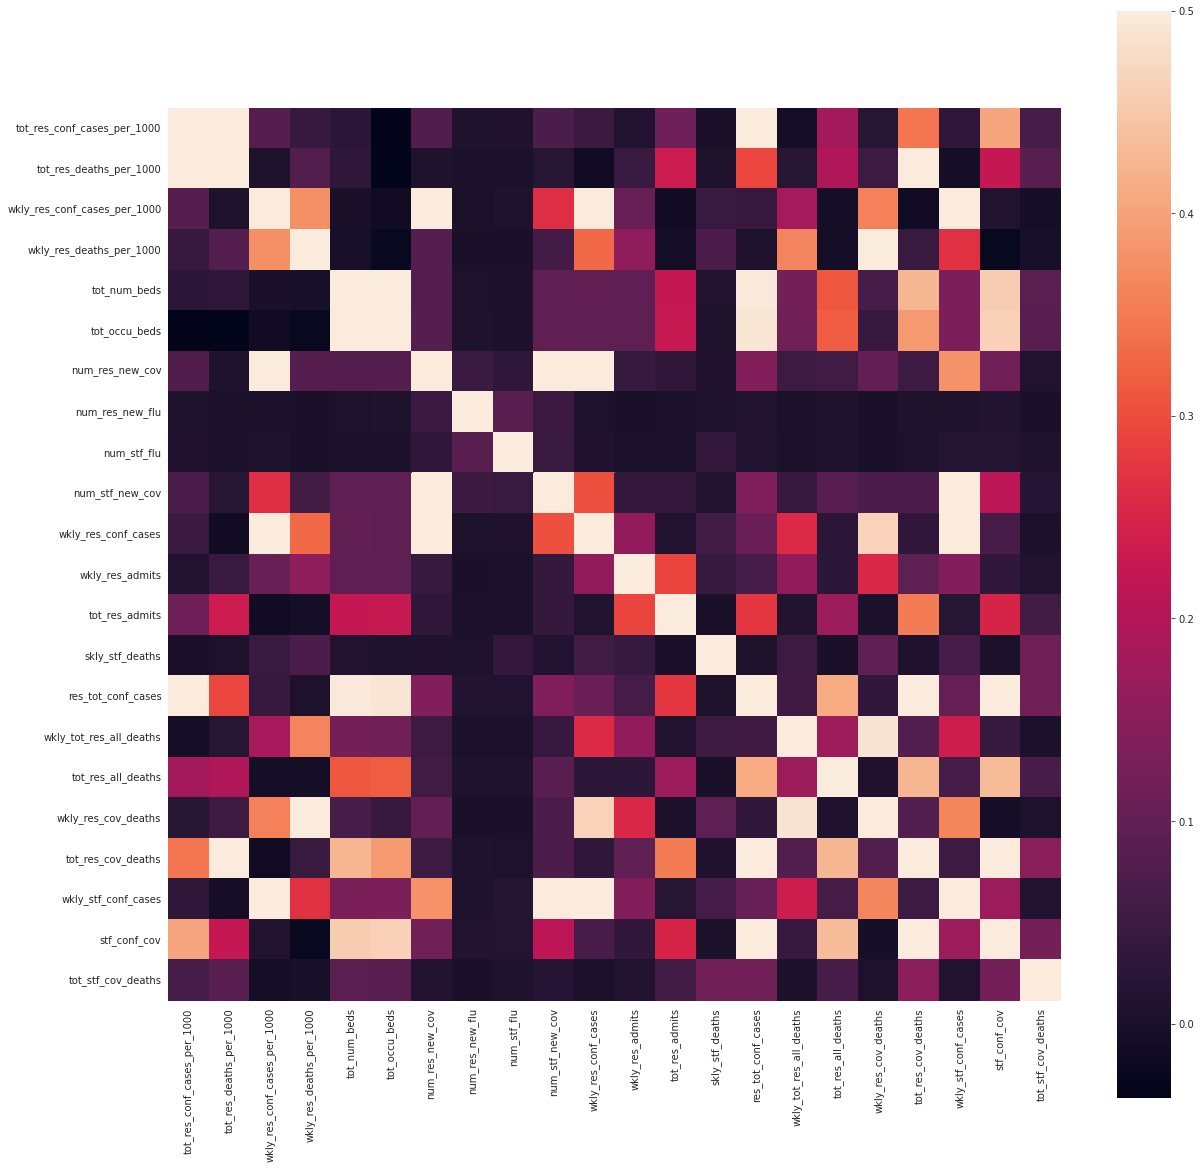

In [42]:
corr_matrix = selected_data.corr()

fig = plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix, vmax = .5, square = True)
plt.show()

### Numeric Dimension Distribution

Plotting Histogram Distribution of Numeric Features on 80% of Data Sample = (1453161, 27)


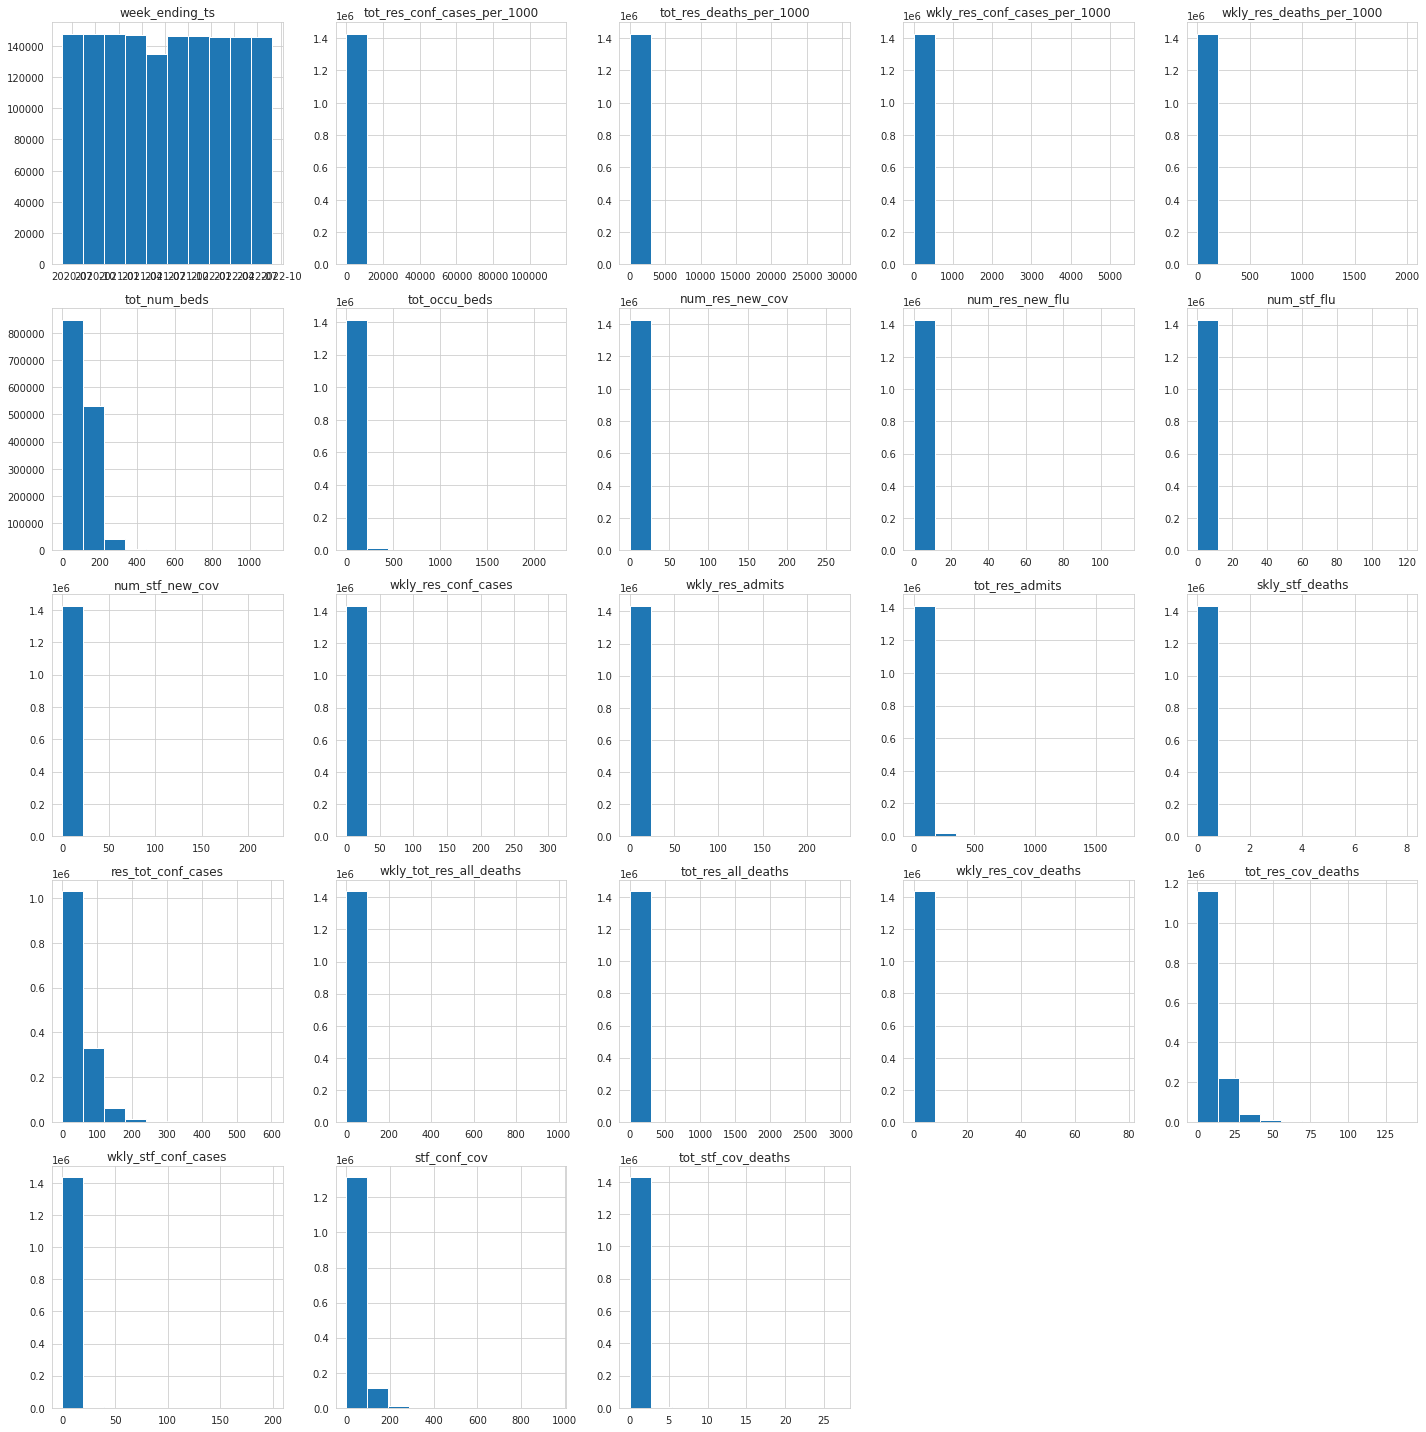

In [43]:
sample_data = selected_data.sample(frac = 0.8, random_state = 365)
print("Plotting Histogram Distribution of Numeric Features \
on 80% of Data Sample = {}".format(sample_data.shape))
sample_data.hist(figsize = (20, 20))
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [44]:
# sns.pairplot(selected_data)

### Categorical Dimension Distribution

In [45]:
# cat_df = tf_data[[col for col in cat_dims]]
# cat_df.head()

In [46]:
# sns.countplot(y='Col1', data=cat_df)

## Feature Engineering